# Imperfect tests and respondent-driven sampling

For now, we consider the network dependence induced by the RDS with no
associated model. Therefore, we treat it as a random effect for
each individual. Conditionally autoregressive (CAR) models in the
Gaussian case are used. Let $[\tilde{Q}]_{ij} = \tilde{q}_{ij}$ be a fixed matrix which measures the distance between $i$
and $j$, and $\tilde{q}_{i+} = \sum_{j} \tilde{q}_{ij}$. In general, we use

$$
\tilde{q}_{ij} = \begin{cases}
  1, &\text{if } i \text{ recruited } j \text{ or the contrary} \\
  0, &\text{otherwise.} 
\end{cases}
$$

Next we define the scaled adjacency matrix $Q = D^{-1}\tilde{Q}$, such that $D$
is a diagonal matrix with $D_{ii} = \tilde{q}_{i+}$. Finally let $|\rho| < 1$ be a
parameter to controls the dependence between neighbors. Hence, we specify the
model as follows:

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta + \omega_i,  \\
    \omega_i|\{\omega_j\}_{j\neq i}, \tau &\sim \operatorname{Normal}\left(\rho\sum_j q_{ij}\omega_j, \tau^{-1}/\tilde{q}_{i+}\right) \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\  
    \tau &\sim \operatorname{Gamma}(a^{\tau}, b^{\tau}).
  \end{aligned}  
\end{equation}

By Brook's Lemma {cite:t}`brook1964distinction`, the joint distribution of
$\omega$ can be specified as 

$$
\omega \sim \operatorname{Normal}\left(0, \left[\tau (D - \rho \tilde{Q})\right]^{-1}\right).
$$

In [1]:
import numpy as np
import pystan as ps
import stan_utility
from scipy.special import logit, expit
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan model 

As usual, we can saved a compiled version for future experiments. 

In [5]:
#compiled = False
compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

Below we can see the necessary information to the stan code. 

In [6]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int T[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
    real<lower = 0> alpha_tau; 
    real<lower = 0> beta_tau;
    
    matrix[n_samples, n_samples] precision; 
    real<lower = 0, upper = 1> rho; 
}
transformed data {
  vector[n_samples] zeros;
  zeros = rep_vector(0, n_samples);
}


The parameters and transformed parameters of the model. 

In [7]:
print(structure[2] + '}' + structure[3] + '}' + structure[4] + '}') 


parameters {
    vector[n_predictors] effects; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
    
    vector[n_samples] omega; 
    real<lower = 0> tau; 
}
transformed parameters {
    vector[n_samples] theta;
    vector[n_samples] p; 
    
    for (i in 1:n_samples) {
        theta[i] = inv_logit(logit(prev) + x[i] * effects + omega[i]);
        p[i] = sens*theta[i] + (1 - spec)*(1 - theta[i]);
    }
}


The model

In [8]:
print(structure[5] + '}' + structure[6] + '}') 


model {
    tau ~ gamma(alpha_tau, beta_tau); 
    omega ~ multi_normal_prec(zeros, tau * precision);

    effects ~ multi_normal(mu, Sigma);
    prev ~ beta(alpha_p, beta_p);
    
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);

    for (i in 1:n_samples) {
       T[i] ~ bernoulli(p[i]);
    }
}


## Toy example

First we describe data created artificially as it was generated by this model.
It serves as a confirmation of functionality of the code. First we get the
data using the class `GenerateData()`. 

In [4]:
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 1000, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                     n_seeds = 10, sample_size = 150, probs = [1/3,1/6,1/6,1/3])

rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))

A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()

n_samples = rds_sample.number_of_nodes()

D = np.diag(A.sum(axis = 1))

Note that we actually only need the adjacency matrix. In the following, we
will use to aggregate that to the entire data. 

In [10]:
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = 200)

# Normalization
x_rds = x[:n_samples]
x_rds = (x_rds - x_rds.mean(axis=0))/x_rds.std(axis = 0, ddof = 1)

In [9]:
# Parameters to generate fake data
tau = 1 
spec = 0.85
sens = 0.8
beta = np.array([0.1, 2.5, -1.0, 1.2, -0.3]).reshape(-1,1)
prevalence = 0.1
rho = 0.5

# Generated quantities
omega = np.random.multivariate_normal(mean = np.zeros(n_samples), 
                                      cov = (1/tau)*np.linalg.inv(D - rho*A), 
                                      ).reshape(-1,1)

theta = expit(logit(prevalence) + (x_rds@beta) + omega)
p = sens*theta + (1 - spec)*(1 - theta)
T = ro.binomial(n = 1, p = p)

# Hyperparameters of the model. 
Sigma   = np.eye(5)
mu      = np.zeros(5)
alpha_p = 1
beta_p  = 3
alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x_rds,
    "precision"    : D - rho*A,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

How the numerical part of the problem enters the picture

```{python}
%%time
fit_rds_imperfect_eff = sm.sampling(data=data, iter=4000)
summary = az.summary(fit_rds_imperfect_eff)
```

This implementation was expected to not converge and take a long time, because
the implementation of CAR is very inefficient.  Because of that, we use [this
implementation](https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html).

## Efficient implementation of CAR

In [12]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient.pkl', 'wb') as f:
        pickle.dump(sm, f)

We use the data generated before. 

In [12]:
Sigma      = np.eye(5)
mu         = np.zeros(5)
alpha_p    = 1
beta_p     = 3
alpha_s    = 4
beta_s     = 1
alpha_e    = 4
beta_e     = 1
lambda_tau = np.log(10)

A_prime = nx.adjacency_matrix(graph.subgraph(rds_sample.nodes)).toarray()

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x_rds,
    "adj_matrix"   : A,
    "adj_pairs"    : int(A.sum()/2),
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
    "lambda_tau"   : lambda_tau,  
    "rho"          : 0.5, 
    "tau"          : 1, 
}

### Distribution for the precision parameter

Commonly used priors with finite mean for $\tau$ will overfit (XXX: Add
reference). Following (XXX: add ref), we use a Penalized Complexity prior for
$\tau$ with the following density:

$$
\pi(\tau) = \frac{\lambda}{2}\tau^{-3/2}\exp(-\lambda\tau^{-1/2}),
$$

which is a type-2 Gumbel precision. 

In [13]:
structure = sm.model_code.split('}')
print(structure[4] + '}') 


  real gumbel_type2_lpdf(real tau, real lambda){
    return log(lambda) - 3/2 * log(tau) - lambda*tau^(-1/2) - log(2); 
  }


In [14]:
%%time
fit_rds_imperfect_eff = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_rds_imperfect_eff)

CPU times: user 37.7 s, sys: 245 ms, total: 38 s
Wall time: 2min 27s


In [15]:
some_parameters = summary.loc[['prev', 'spec','sens', 'effects[0]','effects[1]','effects[2]','effects[3]','effects[4]']]
some_parameters.insert(0, 'real_values', (prevalence, spec, sens, *tuple(beta.flatten())))
some_parameters

,real_values,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prev,0.10,0.448,0.262,0.098,0.830,0.124,0.094,4.0,4.0,6.0,90.0,1.75
spec,0.85,0.633,0.322,0.209,1.000,0.157,0.121,4.0,4.0,6.0,107.0,1.74
sens,0.80,0.499,0.405,0.054,0.993,0.200,0.153,4.0,4.0,6.0,140.0,1.73
effects[0],0.10,0.041,0.343,-0.575,0.719,0.041,0.029,70.0,70.0,78.0,141.0,1.04
effects[1],2.50,-0.138,2.257,-3.264,2.907,1.099,0.838,4.0,4.0,6.0,87.0,1.75
effects[2],-1.00,0.060,0.675,-0.998,1.196,0.299,0.225,5.0,5.0,6.0,93.0,1.72
effects[3],1.20,-0.048,1.154,-1.761,1.564,0.550,0.418,4.0,4.0,6.0,108.0,1.74
effects[4],-0.30,0.015,0.545,-0.875,1.059,0.206,0.152,7.0,7.0,7.0,106.0,1.50


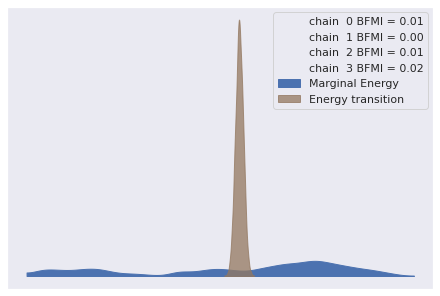

In [17]:
az.plot_energy(fit_rds_imperfect_eff)
plt.show()

In [18]:
info = fit_rds_imperfect_eff.to_dataframe()

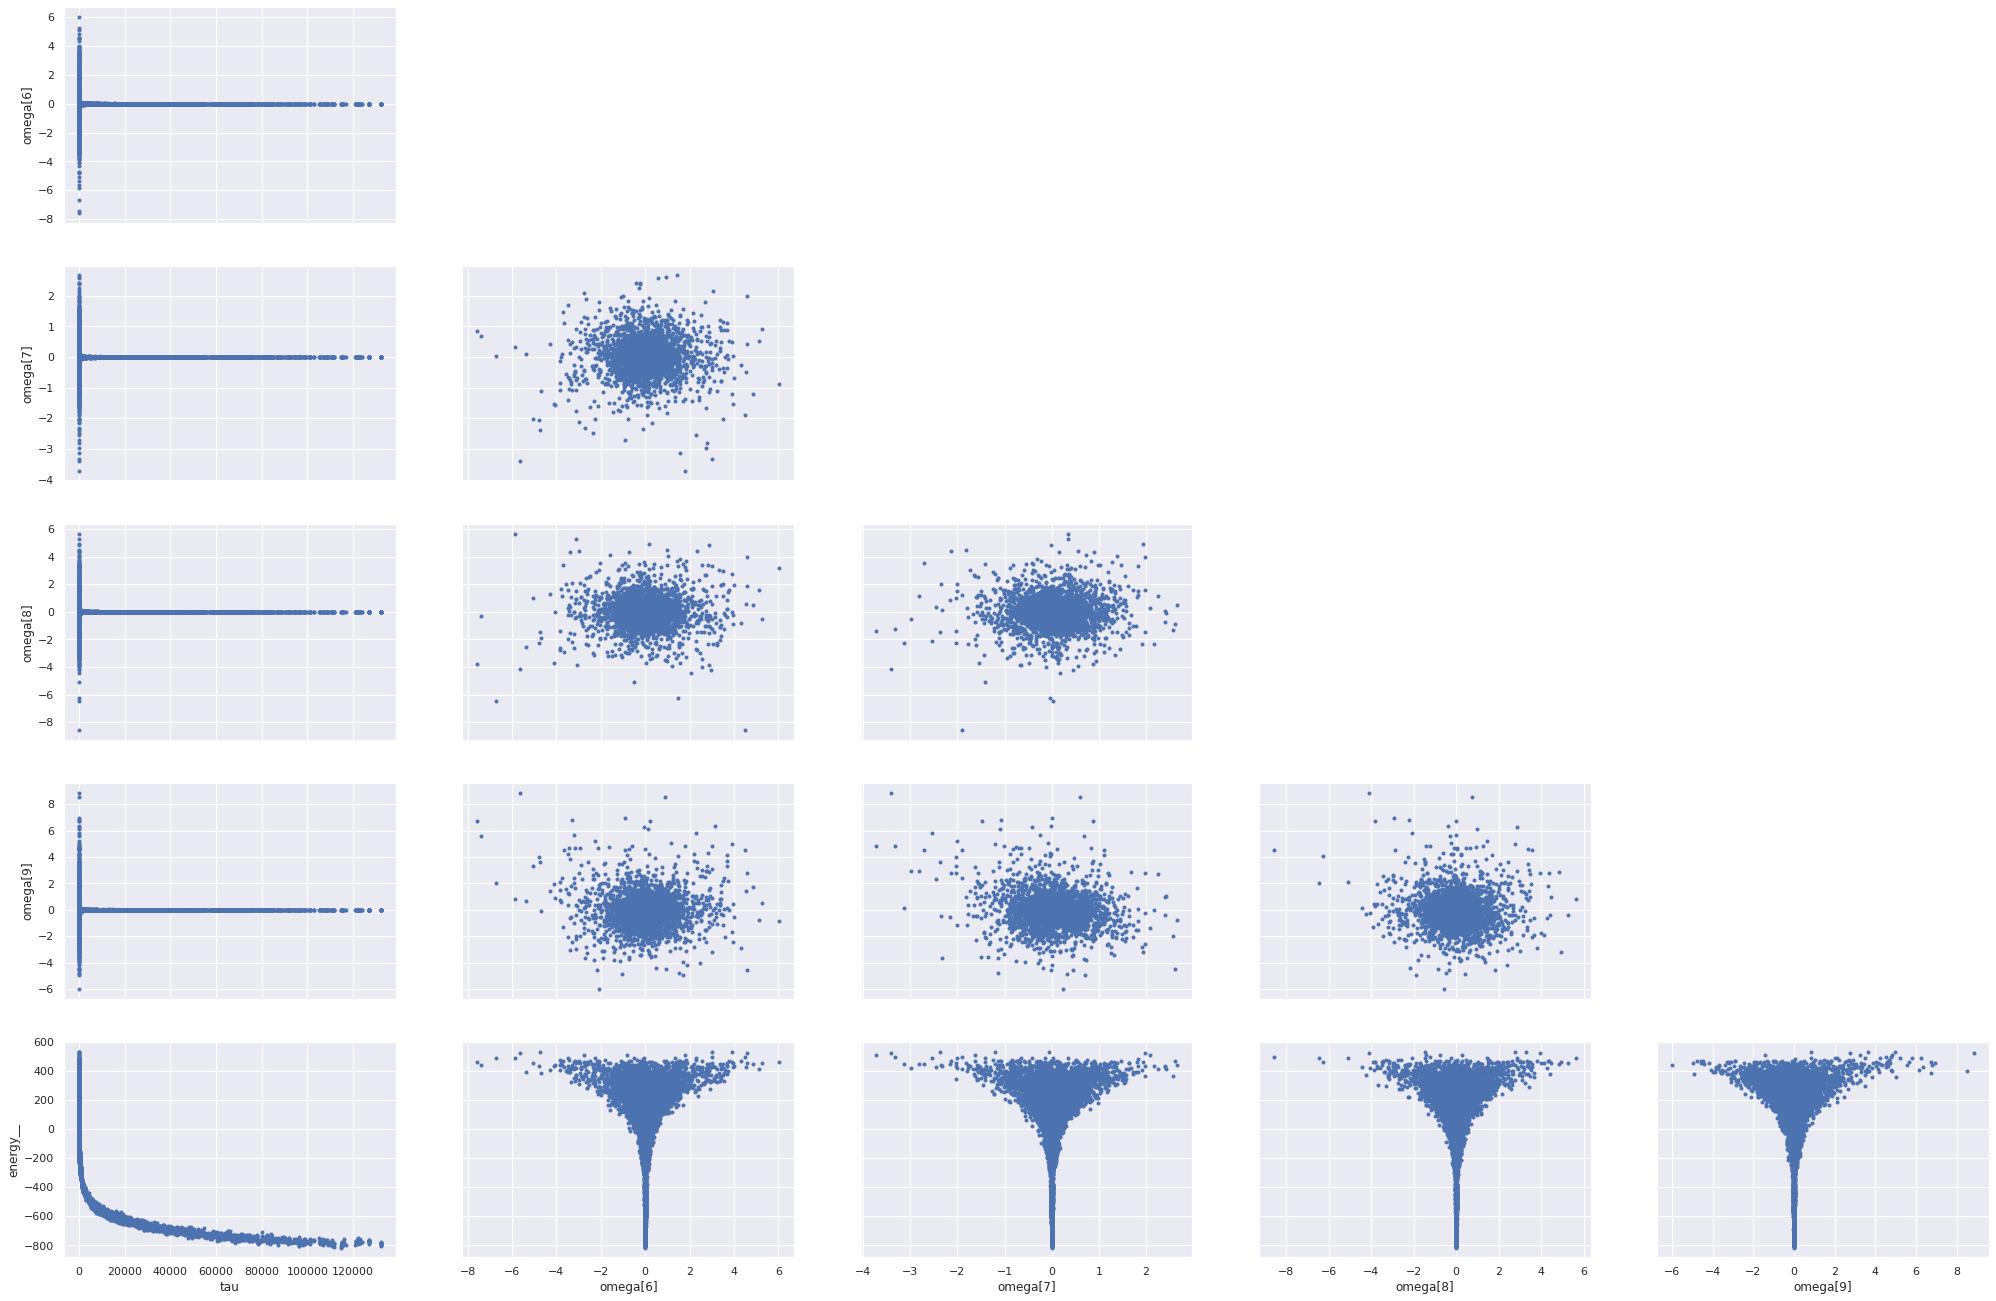

In [19]:
selected_vars = ['tau', 'omega[6]', 'omega[7]', 'omega[8]', 'omega[9]', 'energy__']
samples = {var: info[var] for var in selected_vars}

az.plot_pair(samples)

plt.show()

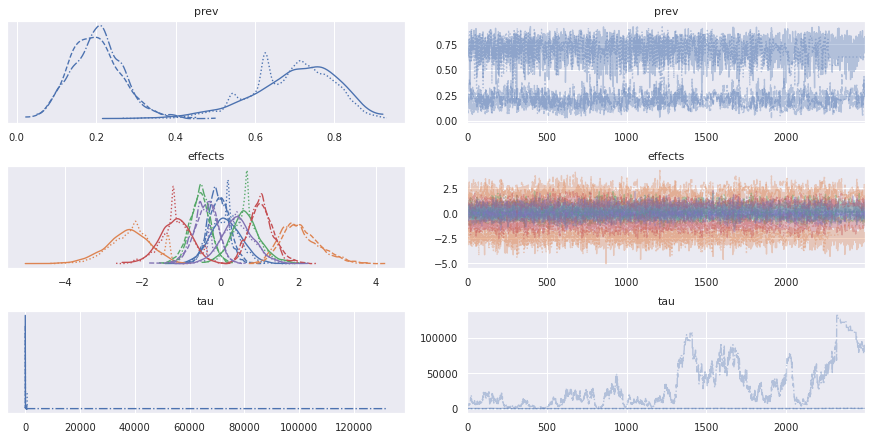

In [20]:
az.plot_trace(fit_rds_imperfect_eff, var_names=('prev', 'effects', 'tau'))
plt.show()

## Testing variations to analyse the problems

Since we are having a lot of problems with the model, we need to simpify and understand where the problem is. We generate the same data to keep track of the different five versions. 

In [160]:
# Parameters to generate fake data
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 1000, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                     n_seeds = 5, sample_size = 100, probs = [1/10,3/10,4/10,2/10])

rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))

A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()
#A = nx.adjacency_matrix(graph.subgraph(rds_sample.nodes)).toarray()

n_samples = rds_sample.number_of_nodes()

D = np.diag(A.sum(axis = 1))

tau = 1
prevalence = 0.1
rho = 0.5

# Generated quantities
omega = np.random.multivariate_normal(mean = np.zeros(n_samples), 
                                      cov = (1/tau)*np.linalg.inv(D - rho*A), 
                                      ).reshape(-1,1)

theta = expit(logit(prevalence) + omega)
T = ro.binomial(n = 1, p = theta)

Starting with version 0: is the efficient implementation without effects, specificity and sensitivity. 

In [15]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v0.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v0.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v0.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [5]:
# Hyperparameters of the model. 
alpha_p = 1
beta_p  = 9
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "T"            : T.flatten(),
    "adj_matrix"   : A,
    "adj_pairs"    : A.sum()//2,

    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

In [6]:
%%time
fit_rds_imperfect_eff_v0 = sm.sampling(data=data, iter=5000, control = {'max_treedepth': 13})
summary = az.summary(fit_rds_imperfect_eff_v0)

CPU times: user 3.04 s, sys: 86.3 ms, total: 3.13 s
Wall time: 1min 48s


In [7]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prev,0.084,0.033,0.024,0.146,0.001,0.001,1081.0,1081.0,937.0,1049.0,1.0
omega[0],-0.040,0.688,-1.362,1.259,0.006,0.014,12638.0,1191.0,13074.0,3014.0,1.0
omega[1],-0.106,0.638,-1.400,1.065,0.007,0.014,8980.0,988.0,11515.0,2222.0,1.0
omega[2],1.003,1.312,-1.191,3.600,0.046,0.033,798.0,791.0,1004.0,1171.0,1.0
omega[3],-0.201,1.134,-2.346,1.950,0.011,0.023,10960.0,1251.0,13396.0,2185.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
theta[68],0.239,0.202,0.008,0.653,0.006,0.004,1171.0,1090.0,1776.0,1565.0,1.0
theta[69],0.104,0.104,0.000,0.280,0.001,0.001,9752.0,7736.0,3489.0,1549.0,1.0
theta[70],0.103,0.100,0.000,0.276,0.001,0.001,10488.0,8328.0,4258.0,1774.0,1.0
theta[71],0.102,0.101,0.000,0.274,0.001,0.001,11003.0,9037.0,4018.0,1876.0,1.0


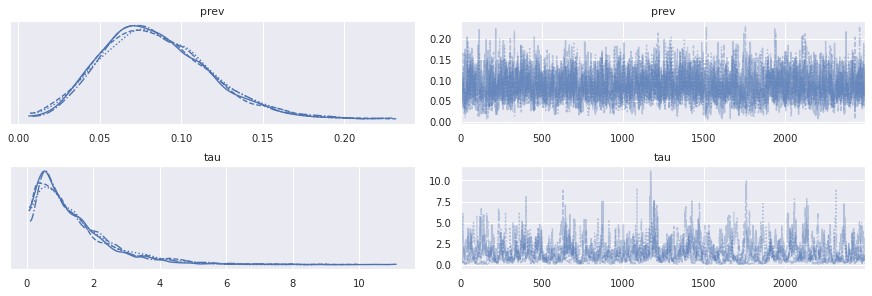

In [8]:
az.plot_trace(fit_rds_imperfect_eff_v0, var_names=('prev', 'tau'))
plt.show()

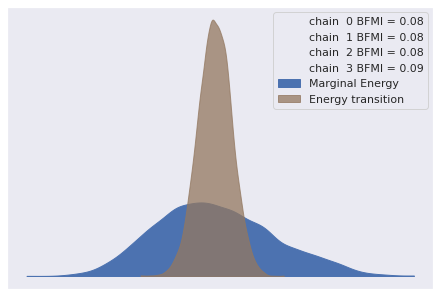

In [9]:
az.plot_energy(fit_rds_imperfect_eff_v0)
plt.show()

0.159Let's try with a second version, considering the approach of IAR given by [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6830524/pdf/nihms-1537693.pdf)

In [23]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v1.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v1.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v1.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [11]:
# Parameters to generate fake data
node1 = []
node2 = []
for i in range(A.shape[0]-1):
    for j in range(i+1, A.shape[0]): 
        if A[i,j] != 0:
            node1.append(i+1)
            node2.append(j+1)

# Hyperparameters of the model. 
alpha_p = 1
beta_p  = 9
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "T"            : T.flatten(),
    "adj_pairs"    : A.sum()//2,
    "node1"        : node1,
    "node2"        : node2,

    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
}

In [12]:
%%time
fit_rds_imperfect_eff_v1 = sm.sampling(data=data, iter=5000, 
                                       control = {'max_treedepth': 12})
summary = az.summary(fit_rds_imperfect_eff_v1)

CPU times: user 2.79 s, sys: 47.9 ms, total: 2.84 s
Wall time: 1min 43s


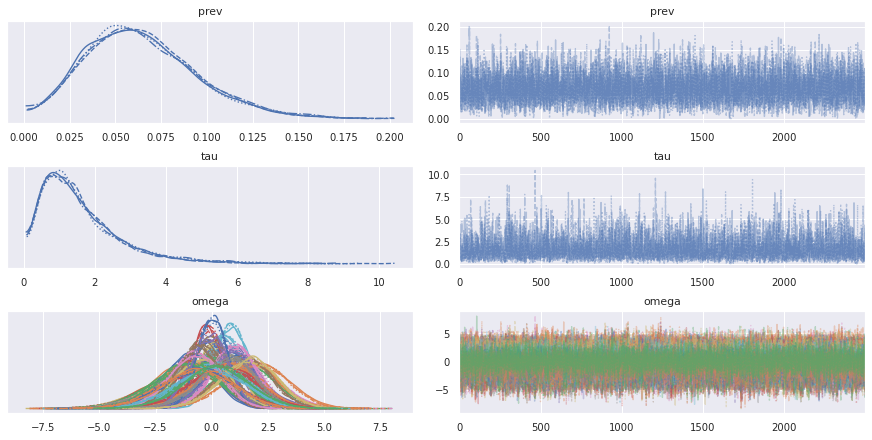

In [30]:
az.plot_trace(fit_rds_imperfect_eff_v1, var_names=('prev', 'tau', 'omega'))
plt.show()

More one version, adapting the first model to have a descentalized CAR. First we consider directly with the prevalence and a beta as its prior. After, we consider a different prior modeling. 

In [25]:
compiled = True
#compiled = False

if compiled:
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v2.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v2.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v2.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [15]:
# Hyperparameters of the model. 
alpha_p = 1
beta_p  = 3
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "T"            : T.flatten(),
    "adj_matrix"   : A,
    "adj_pairs"    : A.sum()//2,

    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

In [16]:
%%time
fit_rds_imperfect_eff_v2 = sm.sampling(data=data, iter=5000, control = {'max_treedepth': 10})
summary = az.summary(fit_rds_imperfect_eff_v2)

CPU times: user 3.17 s, sys: 75.6 ms, total: 3.24 s
Wall time: 8.78 s


In [17]:
summary.loc[['prev', 'tau']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prev,0.085,0.037,0.020,0.153,0.002,0.001,432.0,432.0,394.0,641.0,1.01
tau,1.013,0.868,0.041,2.688,0.051,0.036,291.0,291.0,215.0,441.0,1.02


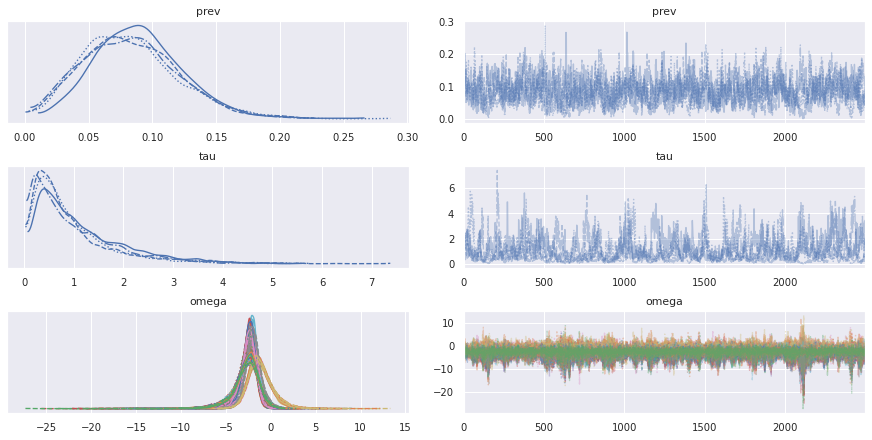

In [18]:
az.plot_trace(fit_rds_imperfect_eff_v2, var_names=('prev', 'tau', 'omega'))
plt.show()

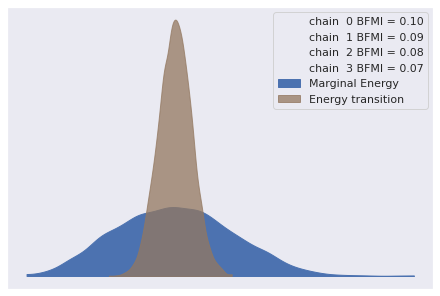

In [19]:
az.plot_energy(fit_rds_imperfect_eff_v2)
plt.show()

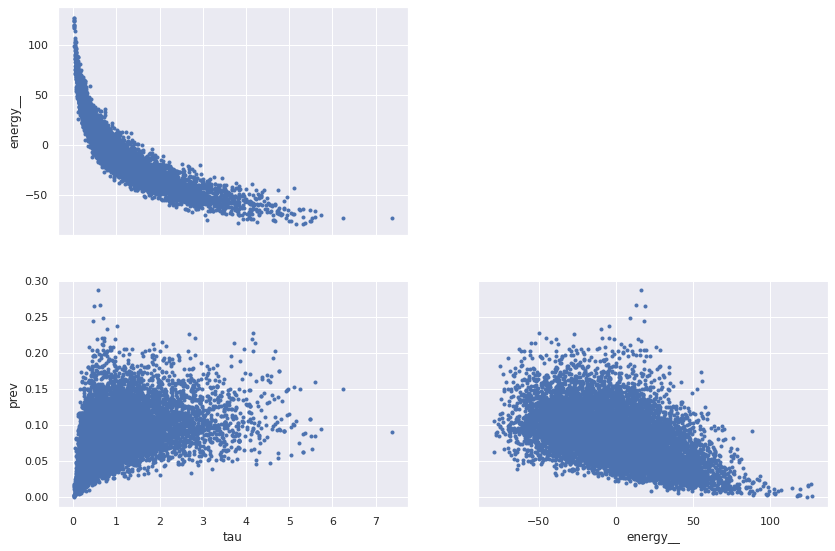

In [20]:
info = fit_rds_imperfect_eff_v2.to_dataframe()
selected_vars = ['tau' ,'energy__', 'prev']
samples = {var: info[var] for var in selected_vars}
samples['energy__'] = samples['energy__'] - samples['energy__'].mean() 

az.plot_pair(samples)

plt.show()

Consider now the modeling of log_prob_odds as normal. 

In [22]:
compiled = True
#compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v3.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v3.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v3.pkl', 'wb') as f:
        pickle.dump(sm, f)

In [22]:
# Hyperparameters of the model. 
mean_mu = -1.5
std_mu  = 1.5
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "T"            : T.flatten(),
    "adj_matrix"   : A,
    "adj_pairs"    : A.sum()//2,

    "mean_mu"      : mean_mu,
    "std_mu"       : std_mu,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

In [23]:
%%time
fit_rds_imperfect_eff_v3 = sm.sampling(data=data, iter=5000, 
                                       control = {'max_treedepth': 10})
summary = az.summary(fit_rds_imperfect_eff_v3)

CPU times: user 3.43 s, sys: 75.9 ms, total: 3.51 s
Wall time: 9.31 s


In [24]:
summary.loc[['mu', 'tau', 'prev']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-2.499,0.528,-3.513,-1.617,0.028,0.020,358.0,337.0,408.0,537.0,1.01
tau,1.115,0.944,0.030,2.896,0.062,0.044,233.0,233.0,194.0,409.0,1.01
prev,0.084,0.035,0.021,0.151,0.002,0.001,456.0,456.0,408.0,537.0,1.01


More one version. But now, considering the non efficient implementation. 

In [71]:
#compiled = True
compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v4.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v4.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v4.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_38e60e0ef6be810a2a9e811d0c561212 NOW.


In [73]:
# Hyperparameters of the model. 
alpha_p = 1
beta_p  = 9
alpha_tau = 1  
beta_tau = 1

data = {
    "n_samples"    : n_samples,
    "T"            : T.flatten(),
    "cov_cholesky" : np.linalg.cholesky(np.linalg.inv(D - rho * A)),

    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "rho"          : rho, 
}

In [74]:
%%time
fit_rds_imperfect_eff_v4 = sm.sampling(data=data, iter=5000, 
                                       control = {'max_treedepth': 10, 'adapt_delta': 0.8})
summary = az.summary(fit_rds_imperfect_eff_v4)

CPU times: user 1.22 s, sys: 95.9 ms, total: 1.32 s
Wall time: 21.5 s


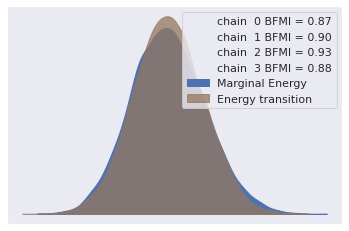

In [75]:
az.plot_energy(fit_rds_imperfect_eff_v4)
plt.show()

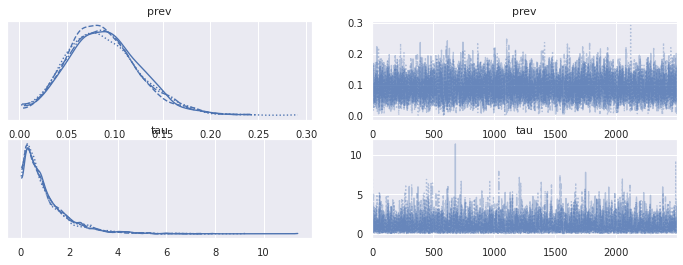

In [76]:
az.plot_trace(fit_rds_imperfect_eff_v4, var_names=('prev', 'tau'))#, 'omega'))
plt.show()

Let's use the efficient implementation, but the scaled version. 

In [119]:
#compiled = True
compiled = False

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v5.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v5.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v5.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e5562482a8a80ff4ea1ef38e41b3cb1b NOW.


In [148]:
# Hyperparameters of the model. 
alpha_p = 1
beta_p  = 9
alpha_tau = 2
beta_tau = 2

data = {
    "n_samples"    : n_samples,
    "T"            : T.flatten(),
    "adj_matrix"   : A,
    "adj_pairs"    : A.sum()//2,

    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_tau"    : alpha_tau, 
    "beta_tau"     : beta_tau, 
    "lambda_tau"   : np.log(10),
    "gumbel_prior" : 0,
    "rho"          : rho, 
}

In [83]:
%%time
fit_rds_imperfect_eff_v5 = sm.sampling(data=data, iter=4000, control = {'adapt_delta': 0.8})
summary = az.summary(fit_rds_imperfect_eff_v5)

CPU times: user 3.53 s, sys: 78.2 ms, total: 3.61 s
Wall time: 8.59 s


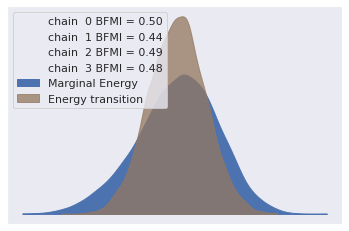

In [84]:
az.plot_energy(fit_rds_imperfect_eff_v5)
plt.show()

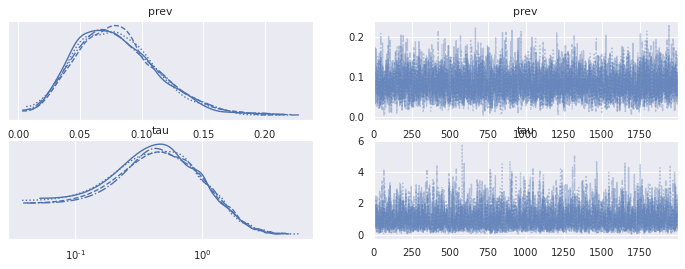

In [16]:
ax = az.plot_trace(fit_rds_imperfect_eff_v5, var_names=('prev', 'tau'))#, 'omega'))
ax[1,0].set_xscale('log')
plt.show()

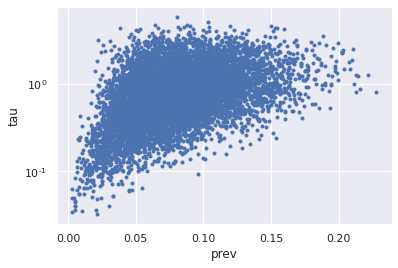

In [17]:
inference_data = az.convert_to_inference_data(fit_rds_imperfect_eff_v5)
fig, ax = plt.subplots()
az.plot_pair(inference_data, var_names=('prev', 'tau'), divergences=True, group = 'posterior', ax = ax)
ax.set_yscale('log')
plt.show()

We can observe the overfitting below 

In [20]:
summary.loc[['prev', 'tau']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.080,0.034,0.02,0.142,0.000,0.000,6385.0,4089.0,1.0
tau,0.959,0.682,0.06,2.217,0.009,0.006,4782.0,4205.0,1.0


### Gumbel distribution

In [149]:
data.update({
    "lambda_tau"   : np.log(10),
    "gumbel_prior" : 1,
})

In [156]:
%%time
fit_rds_imperfect_eff_v5 = sm.sampling(data=data, iter=4000, 
                                       control = {'max_treedepth': 10, 'adapt_delta': 0.8})
summary = az.summary(fit_rds_imperfect_eff_v5)

CPU times: user 3.36 s, sys: 106 ms, total: 3.47 s
Wall time: 9.8 s


In [157]:
summary.loc[['prev', 'tau', 'rho']]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.106,0.028,0.056,0.162,0.000,0.000,4973.0,3427.0,1.0
tau,17360.291,416003.332,0.096,1877.591,5154.944,3645.259,2466.0,3022.0,1.0
rho,0.466,0.280,0.004,0.910,0.010,0.008,737.0,889.0,1.0


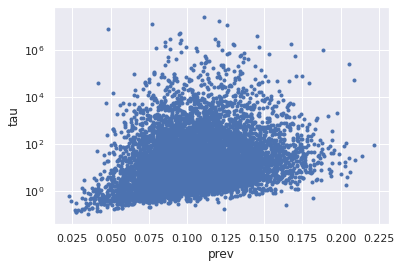

In [158]:
inference_data = az.convert_to_inference_data(fit_rds_imperfect_eff_v5)
fig, ax = plt.subplots()
az.plot_pair(inference_data, var_names=('prev', 'tau'), divergences=True, group = 'posterior', ax = ax)
ax.set_yscale('log')
plt.show()

### Vectorization 

Comparing the vector implementation with the for implementation. 

In [13]:
compiled = True

if compiled: 
    sm1 = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v5_not_v.pkl', 'rb'))
else: 
    sm1 = ps.StanModel(file = '../models/primary_model/stan_codes/rds_imperfect_test_efficient_v5_not_v.stan')
    with open('../models/primary_model/pickles/rds_imperfect_test_efficient_v5_not_v.pkl', 'wb') as f:
        pickle.dump(sm1, f)
sm2 = pickle.load(open('../models/primary_model/pickles/rds_imperfect_test_efficient_v5.pkl', 'rb'))

In [18]:
# Parameters to generate fake data
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 1000, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 2000, 
                                     n_seeds = 2, sample_size = 100, probs = [1/10,3/10,4/10,2/10])

rds_sample.remove_nodes_from(list(nx.isolates(rds_sample)))

A = nx.adjacency_matrix(rds_sample.to_undirected()).toarray()

n_samples = rds_sample.number_of_nodes()

D = np.diag(A.sum(axis = 1))

tau = 1 
prevalence = 0.1
rho = 0.5

# Generated quantities
omega = np.random.multivariate_normal(mean = np.zeros(n_samples), 
                                      cov = (1/tau)*np.linalg.inv(D - rho*A), 
                                      ).reshape(-1,1)

theta = expit(logit(prevalence) + omega)
T = ro.binomial(n = 1, p = theta)

In [20]:
%%time
fit1 = sm1.sampling(data=data, iter=4000)

CPU times: user 778 ms, sys: 83.1 ms, total: 861 ms
Wall time: 39.5 s


In [22]:
%%time
fit2 = sm2.sampling(data=data, iter=4000)

CPU times: user 732 ms, sys: 60.6 ms, total: 792 ms
Wall time: 3.07 s
